In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re


# Our prediction target is directly related to salary
df = pd.read_csv("data.csv", encoding='latin-1')
df=df.dropna(subset='salary')
df = df.reset_index(drop=True)

### Salary Analysis

In [2]:
year_count = 0
month_count = 0
week_count = 0
day_count = 0
hour_count = 0
unit_count = 0

from_count = 0
upto_count = 0 
dash_count = 0
interval_year_idx = []
other = []

for idx, salary in enumerate(df['salary'], 0):
    hour = re.search(r'hour', salary)
    day = re.search(r'day', salary)
    week = re.search(r'week', salary)
    month = re.search(r'month', salary)
    year = re.search(r'year', salary)
    from_ = re.search(r'From', salary)
    upto = re.search(r'Up', salary)
    dash = re.search(r'-', salary)
    if hour:
        hour_count += 1
    elif day:
        day_count += 1
    elif week:
        week_count += 1
    elif month:
        month_count += 1
    elif year:
        year_count += 1
        if dash:
            interval_year_idx.append(idx)
    else:
        unit_count += 1
        
    if from_:
        from_count += 1
    elif upto:
        upto_count += 1
    elif dash:
        dash_count += 1
    else:
        other.append(salary)

print("hour count:", hour_count)
print("day count:", day_count)
print("week count:", week_count)
print("month count:", month_count)
print("year count:", year_count)
print('other unit count:', unit_count)
print("total = ", hour_count + day_count + week_count + month_count + year_count)


print("\nfrom count:", from_count)
print("upto count:", upto_count)
print("dash count:", dash_count)

hour count: 3198
day count: 33
week count: 15
month count: 317
year count: 14540
other unit count: 0
total =  18103

from count: 1788
upto count: 665
dash count: 14434


In [3]:
# drop the salary whose format is not interval and yearly
df = df[df.index.isin(interval_year_idx)]
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11824 entries, 0 to 11823
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  11824 non-null  object 
 1   company                11824 non-null  object 
 2   salary                 11824 non-null  object 
 3   rating                 11824 non-null  float64
 4   review_count           11824 non-null  int64  
 5   types                  10410 non-null  object 
 6   location               11824 non-null  object 
 7   relative_time          11824 non-null  object 
 8   hires_needed           5088 non-null   object 
 9   hires_needed_exact     8125 non-null   object 
 10  urgently_hiring        11824 non-null  bool   
 11  remote_work_model      6800 non-null   object 
 12  snippet                11824 non-null  object 
 13  dradis_job             11824 non-null  bool   
 14  link                   11824 non-null  object 
 15  ne

### Feature Analysis

In [4]:
# Extract information from salary
df['salary_min'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[0].replace(',', '', regex=True).astype(float)
df['salary_max'] = df['salary'].str.extract(r'\$(\d+,*\d*) - \$(\d+,*\d*)\sa\s(\w+)')[1].replace(',', '', regex=True).astype(float)
df['average_salary'] = (df['salary_min'] + df['salary_max']) / 2

# Calculate the ratio M/m
df['salary_ratio'] = df['salary_max'] / df['salary_min']

# Classify into Low, Medium, or High based on the specified criteria
df['salary_range'] = pd.cut(df['salary_ratio'],
                            bins=[-float('inf'), 1.25, 1.5, float('inf')],
                            labels=['Low', 'Medium', 'High'],
                            right=False) # Ensure that the intervals are left-closed


# Print the count of each salary range
print(df['salary_range'].value_counts())

salary_range
Medium    5331
High      3480
Low       3013
Name: count, dtype: int64


In [5]:
# Classify features

boolean_features = ['urgently_hiring', 'dradis_job', 'new_job', 'sponsored', 'featured_employer', 'indeed_applyable', 'remote_location', 'hiring_event_job']

categorical_features = ['types', 'remote_work_model', 'hires_needed_exact', 'company', 'location', 'salary_range']

numerical_features = ['rating', 'review_count', 'salary_range']

text_features = ['snippet', 'title']

<Figure size 1200x800 with 0 Axes>

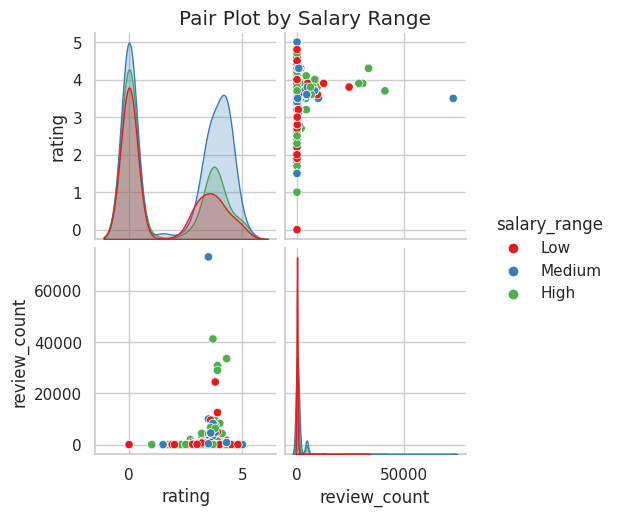

In [6]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
g = sns.pairplot(data=df[numerical_features], hue='salary_range', palette='Set1')
g.fig.suptitle("Pair Plot by Salary Range", y=1.02)

plt.show()

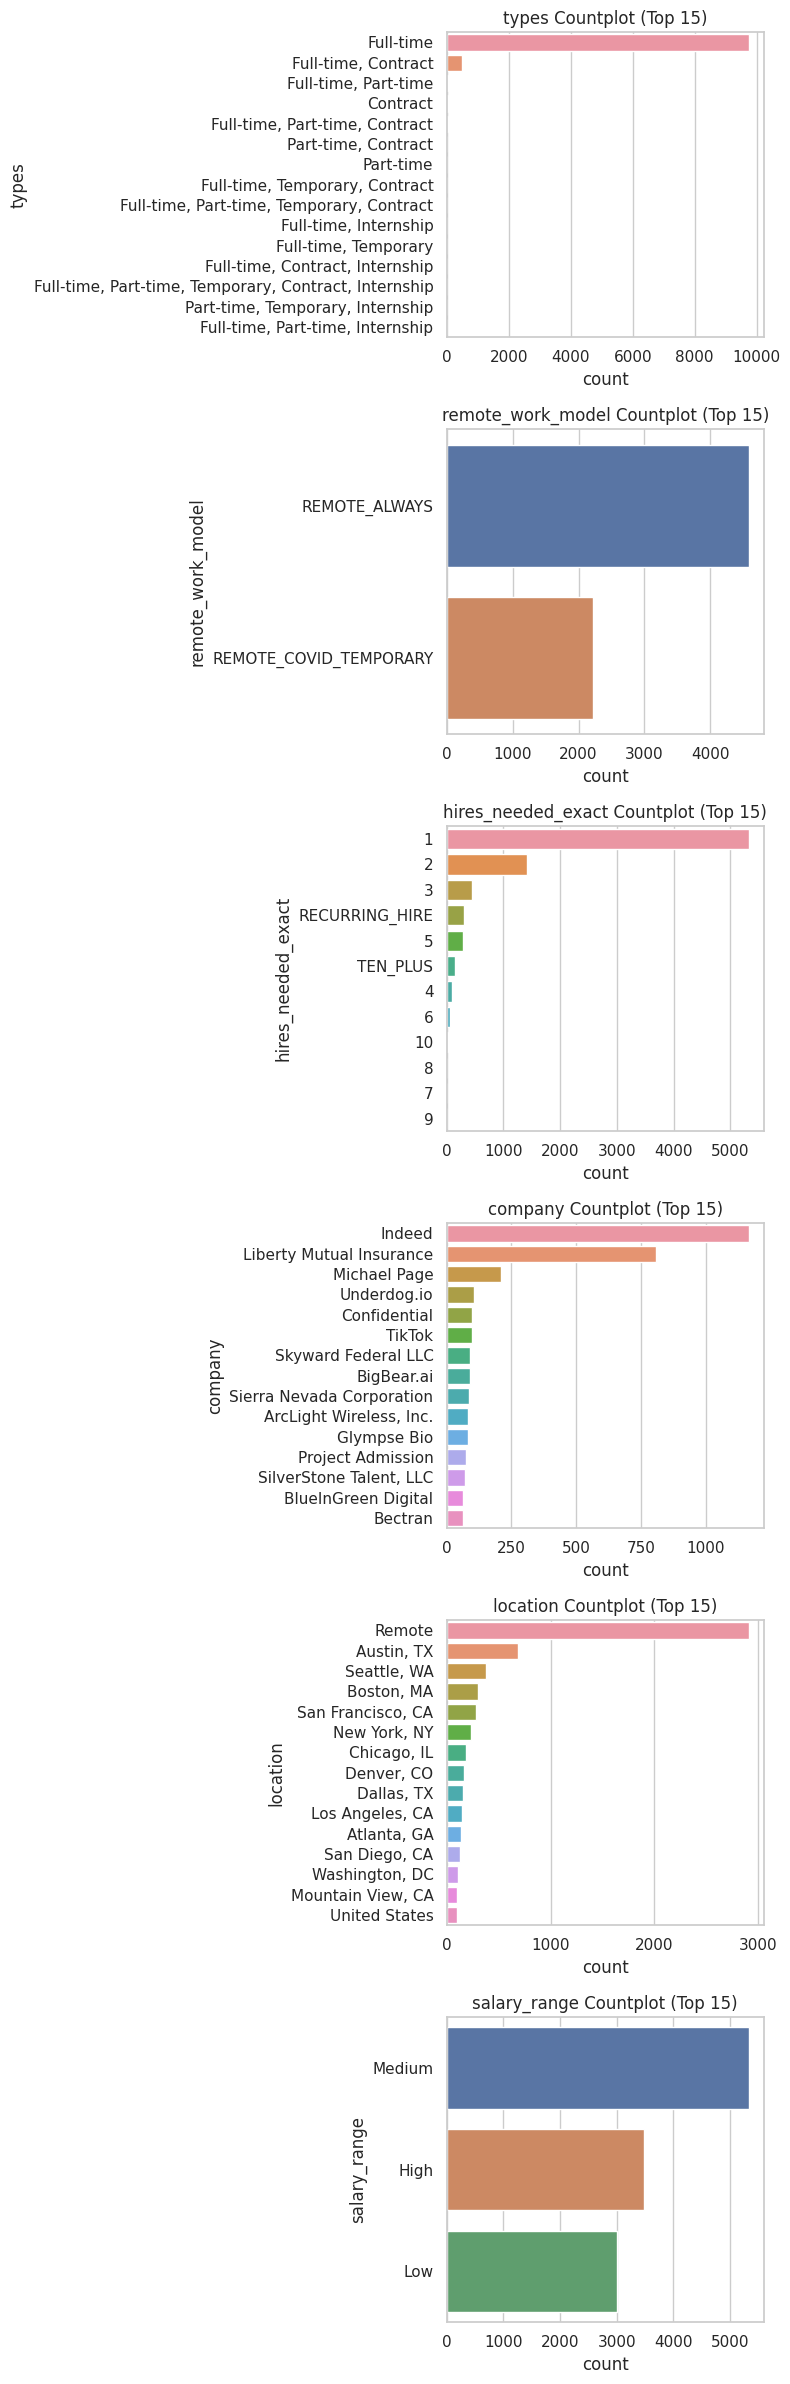

In [7]:
# Set the top N classes to display
top_n = 15

# Set up subplots
fig, axes = plt.subplots(nrows=len(categorical_features), figsize=(8, 4 * len(categorical_features)))

# Plot countplots for each categorical feature
for i, feature in enumerate(categorical_features):
    # Select the top N classes based on frequency
    top_classes = df[feature].value_counts().nlargest(top_n).index
    sns.countplot(y=feature, data=df[df[feature].isin(top_classes)], ax=axes[i], order=top_classes)
    axes[i].set_title(f'{feature} Countplot (Top {top_n})')

plt.tight_layout()
plt.show()


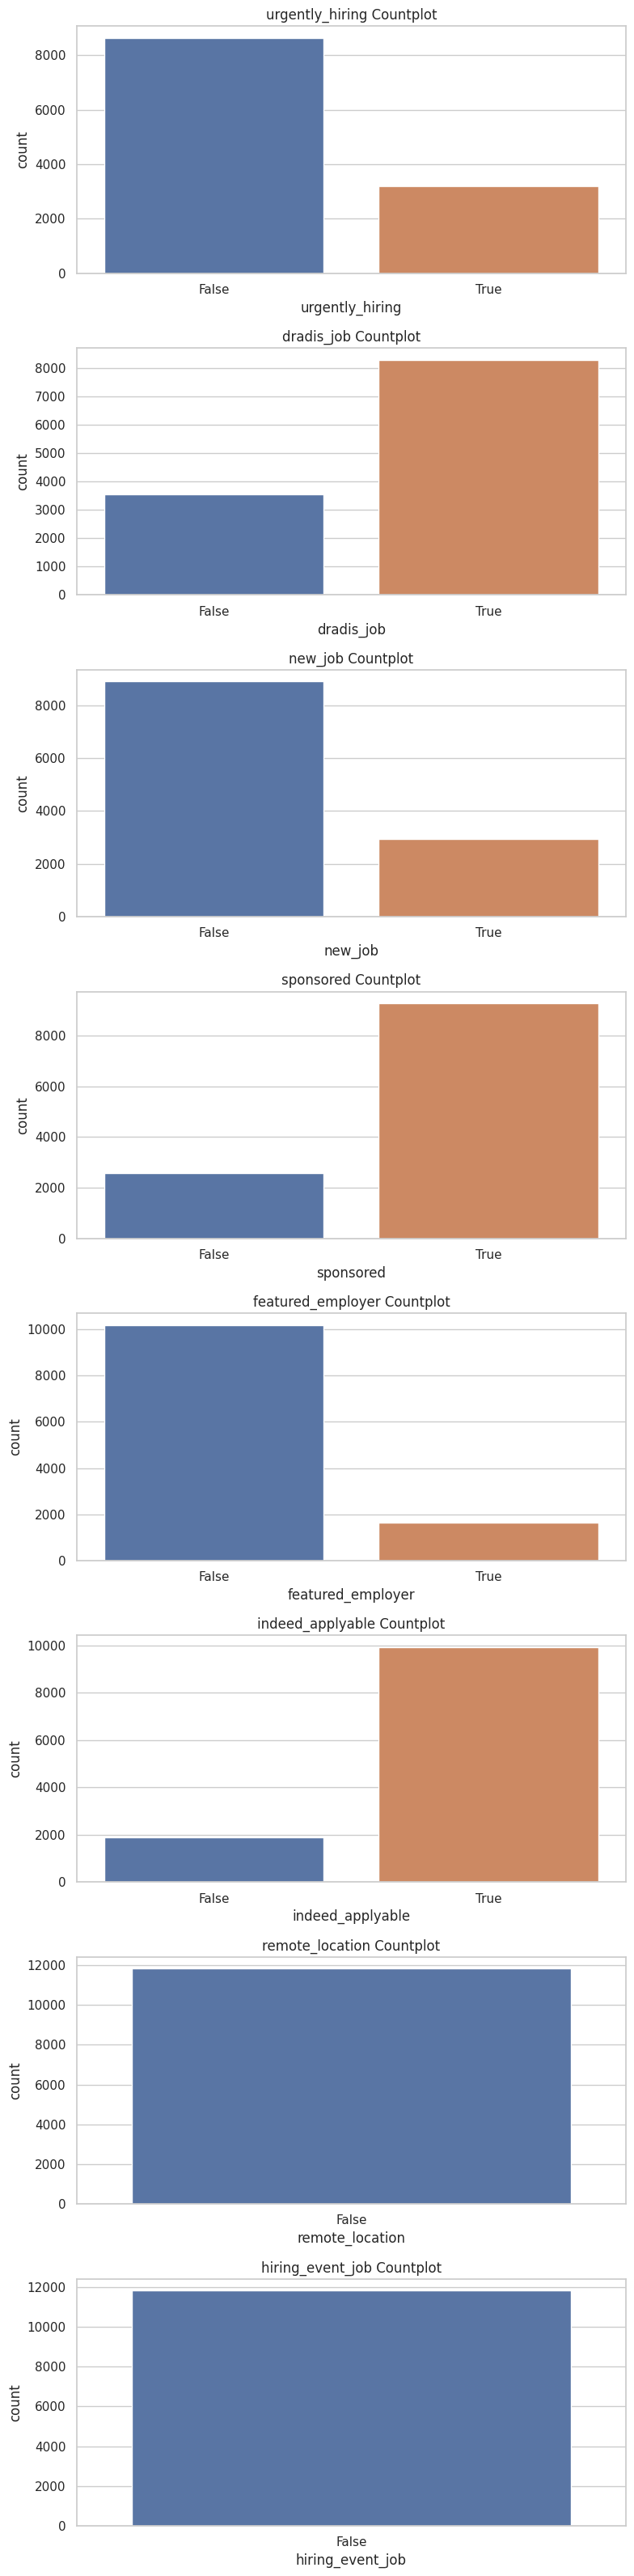

In [8]:
# Set up subplots
fig, axes = plt.subplots(nrows=len(boolean_features), figsize=(8, 4 * len(boolean_features)))

# Plot countplots for each categorical feature
for i, feature in enumerate(boolean_features):
    # Select the top N classes based on frequency
    sns.countplot(x=feature, data=df, ax=axes[i])
    axes[i].set_title(f'{feature} Countplot')

plt.tight_layout()
plt.show()

### Text Feature Analysis

In [9]:
df['snippet Total Words'] = df['snippet'].apply(lambda x: len(x.split()))
df['snippet Total Chars'] = df['snippet'].apply(lambda x: sum(len(word) for word in x.split()))

df['title Total Words'] = df['title'].apply(lambda x: len(x.split()))
df['title Total Chars'] = df['title'].apply(lambda x: sum(len(word) for word in x.split()))

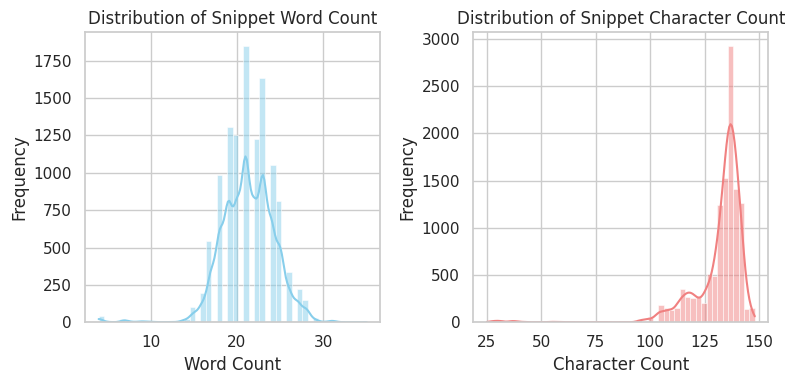

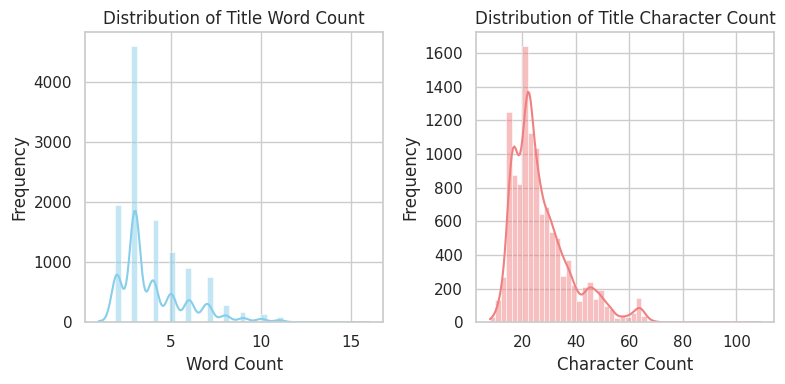

In [10]:
plt.figure(figsize=(8, 4))
# Plot histogram for the number of words
plt.subplot(1, 2, 1)
sns.histplot(x='snippet Total Words', data=df, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Snippet Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot histogram for the number of characters
plt.subplot(1, 2, 2)
sns.histplot(df['snippet Total Chars'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Snippet Character Count')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
# Plot histogram for the number of words
plt.subplot(1, 2, 1)
sns.histplot(x='title Total Words', data=df, bins=50, kde=True, color='skyblue')
plt.title('Distribution of Title Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Plot histogram for the number of characters
plt.subplot(1, 2, 2)
sns.histplot(df['title Total Chars'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Title Character Count')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

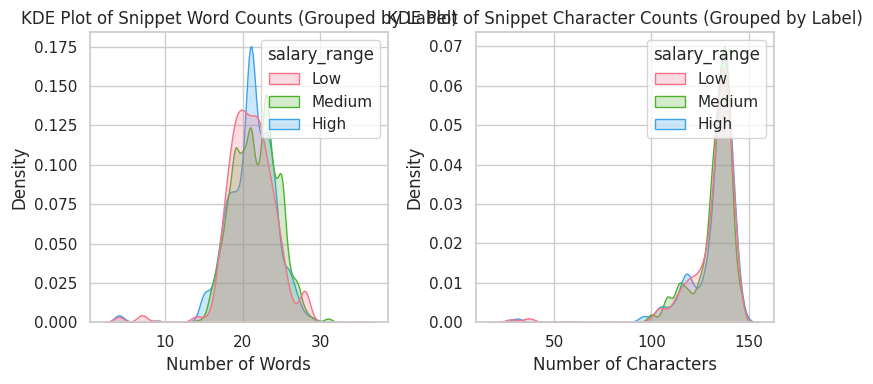

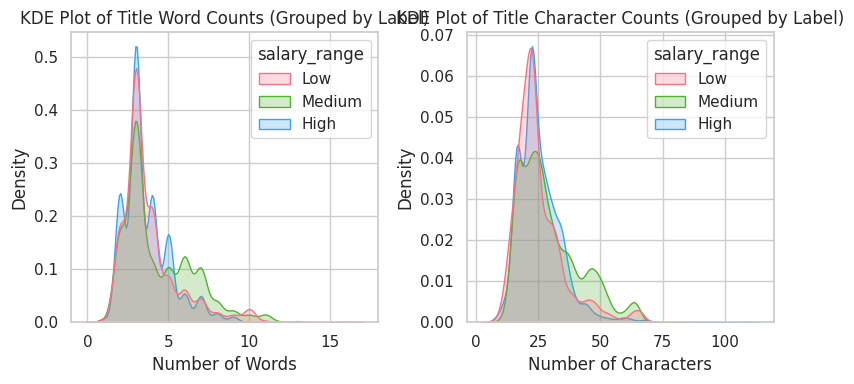

In [11]:
# Plotting KDEs and boxplots
plt.figure(figsize=(8, 4))
# KDE plot for the number of words grouped by 'label'
plt.subplot(1, 2, 1)
sns.kdeplot(x='snippet Total Words', data=df, hue='salary_range', common_norm=False, fill=True, palette='husl')
plt.title('KDE Plot of Snippet Word Counts (Grouped by Label)')
plt.xlabel('Number of Words')
plt.ylabel('Density')

# KDE plot for the number of characters grouped by 'label'
plt.subplot(1, 2, 2)
sns.kdeplot(x='snippet Total Chars', data=df, hue='salary_range', common_norm=False, fill=True, palette='husl')
plt.title('KDE Plot of Snippet Character Counts (Grouped by Label)')
plt.xlabel('Number of Characters')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


# Plotting KDEs and boxplots
plt.figure(figsize=(8, 4))
# KDE plot for the number of words grouped by 'label'
plt.subplot(1, 2, 1)
sns.kdeplot(x='title Total Words', data=df, hue='salary_range', common_norm=False, fill=True, palette='husl')
plt.title('KDE Plot of Title Word Counts (Grouped by Label)')
plt.xlabel('Number of Words')
plt.ylabel('Density')

# KDE plot for the number of characters grouped by 'label'
plt.subplot(1, 2, 2)
sns.kdeplot(x='title Total Chars', data=df, hue='salary_range', common_norm=False, fill=True, palette='husl')
plt.title('KDE Plot of Title Character Counts (Grouped by Label)')
plt.xlabel('Number of Characters')
plt.ylabel('Density')

plt.tight_layout()